In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tensorflow in c:\users\rocks\appdata\local\programs\python\python312\lib\site-packages (2.16.0rc0)




[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [6]:
data_dir = 'C:\\Users\\rocks\\Documents\\MAIN PROJECT\\MANGO LEAF DS'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Anthracnose
1,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Anthracnose
2,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Anthracnose
3,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Anthracnose
4,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Anthracnose
...,...,...
3995,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Sooty Mould
3996,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Sooty Mould
3997,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Sooty Mould
3998,C:\Users\rocks\Documents\MAIN PROJECT\MANGO LE...,Sooty Mould


In [8]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [9]:
# Set the batch size, image size, number of channels, and image shape
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the batch size for test data dynamically
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Define a custom function for data augmentation (no augmentation in this case)
def scalar(img):
    return img

# Create ImageDataGenerator for training and testing
tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

# Generate training data batches from the dataframe
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

# Generate validation data batches from the dataframe
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

# Generate test data batches from the dataframe (with custom batch size and no shuffling)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


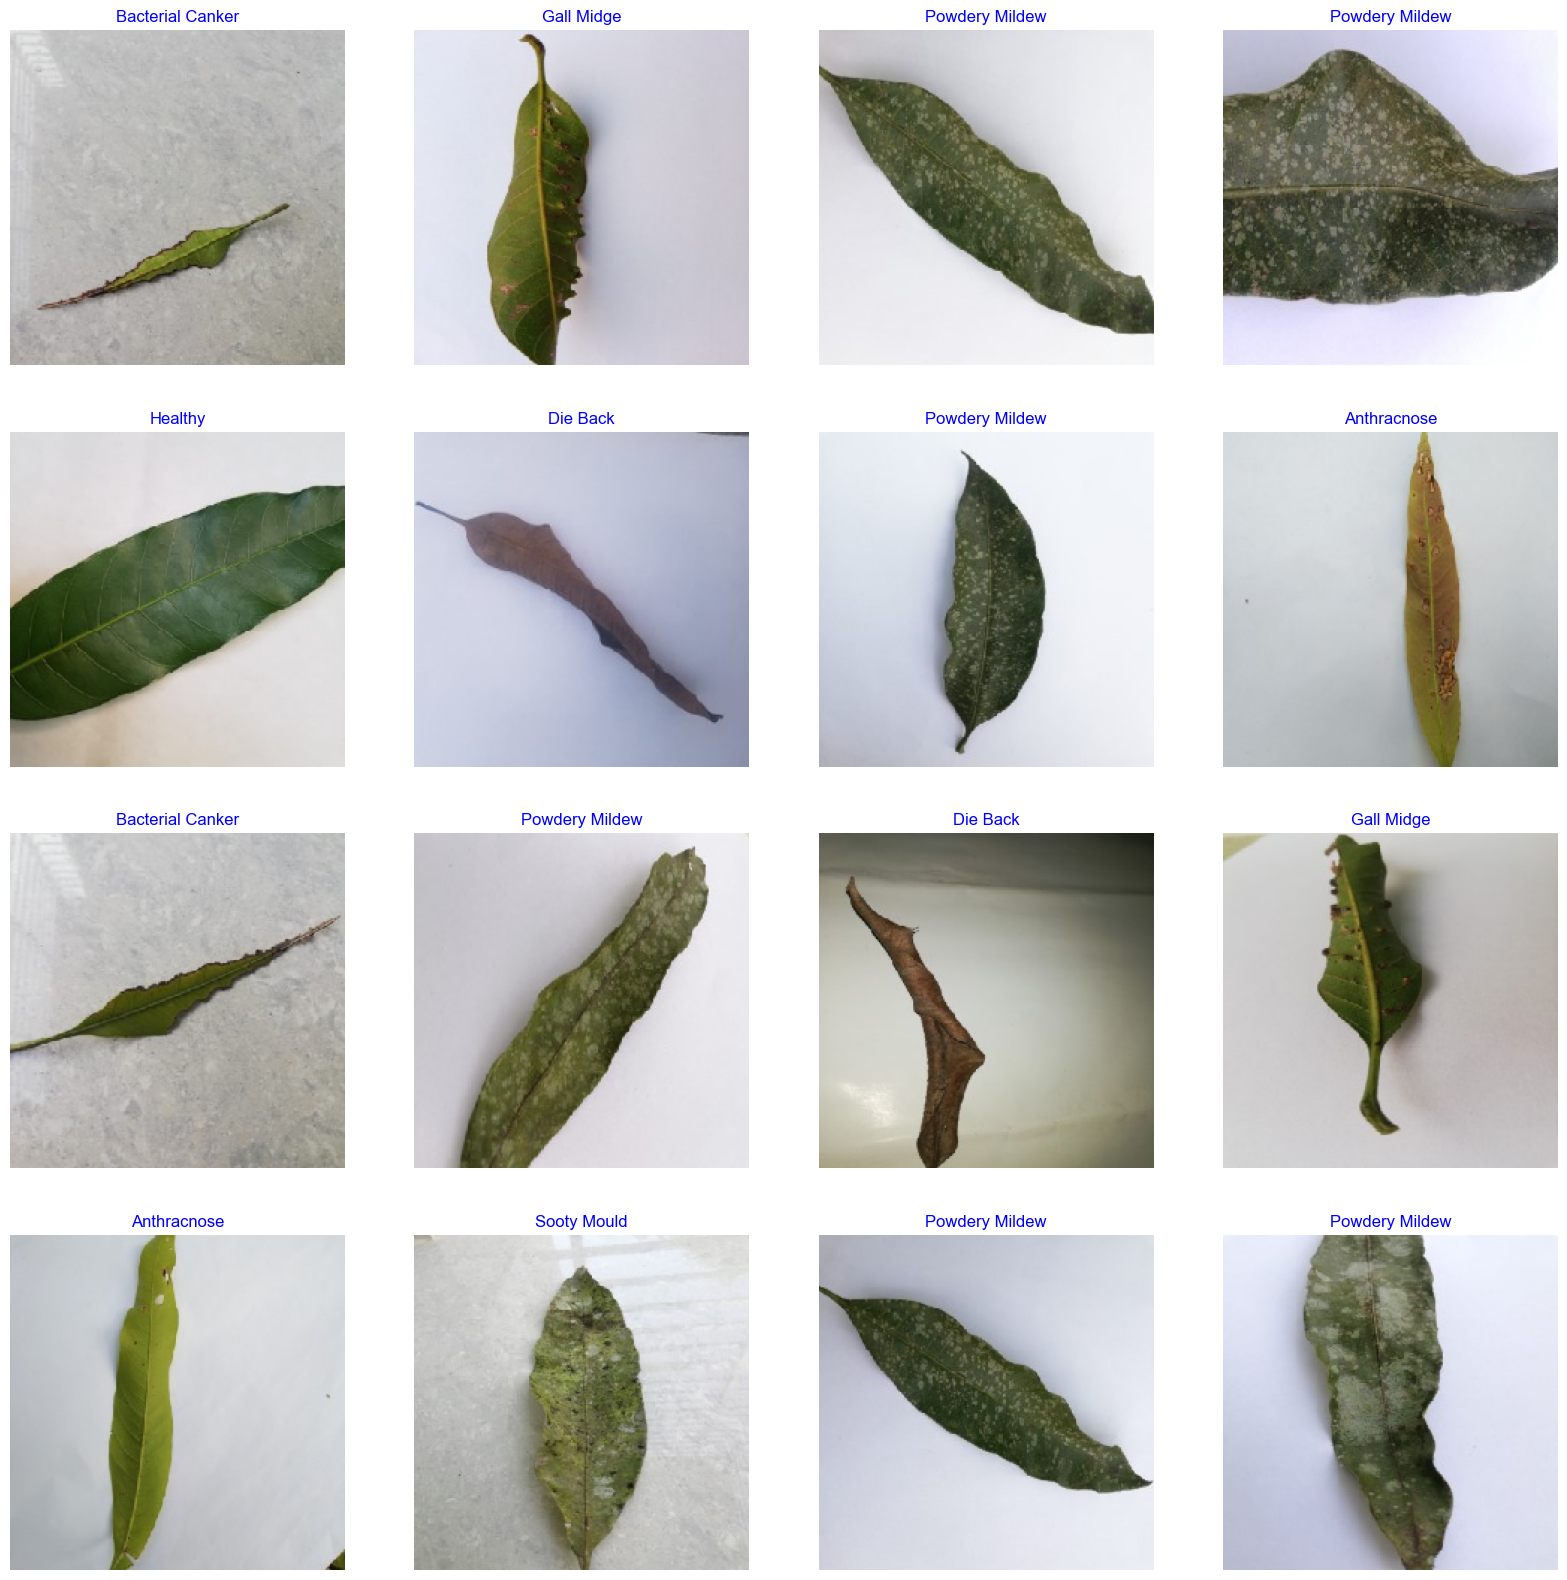

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can build on a pre-trained model such as EfficientNet, VGG, or ResNet)
# we will use EfficientNetB3 from the EfficientNet family.
base_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model.build(input_shape=(None, img_size[0], img_size[1], channels))  # Explicitly build the model with input shape
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1000)           │   138,357,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,619,856 (528.79 MB)

 Trainable params: 260,312 (1016.84 KB)

 Non-trainable params: 138,359,544 (527.80 MB)

In [35]:
batch_size = 16  # set batch size for training
epochs = 12   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.7541 - loss: 1.4650 - val_accuracy: 0.7875 - val_loss: 1.3521
Epoch 2/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.7523 - loss: 1.4185 - val_accuracy: 0.7937 - val_loss: 1.3115
Epoch 3/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.7505 - loss: 1.3813 - val_accuracy: 0.8042 - val_loss: 1.2831
Epoch 4/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.7758 - loss: 1.3577 - val_accuracy: 0.8083 - val_loss: 1.2522
Epoch 5/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7599 - loss: 1.3349 - val_accuracy: 0.8104 - val_loss: 1.2303
Epoch 6/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.7821 - loss: 1.3165 - val_accuracy: 0.8208 - val_loss: 1.2100
Epoch 7/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.8014 - loss: 1.2536 - val_accuracy: 0.8271 - val_loss: 1.1856
Epoch 8/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7940 - loss: 1.2557 - val_accu

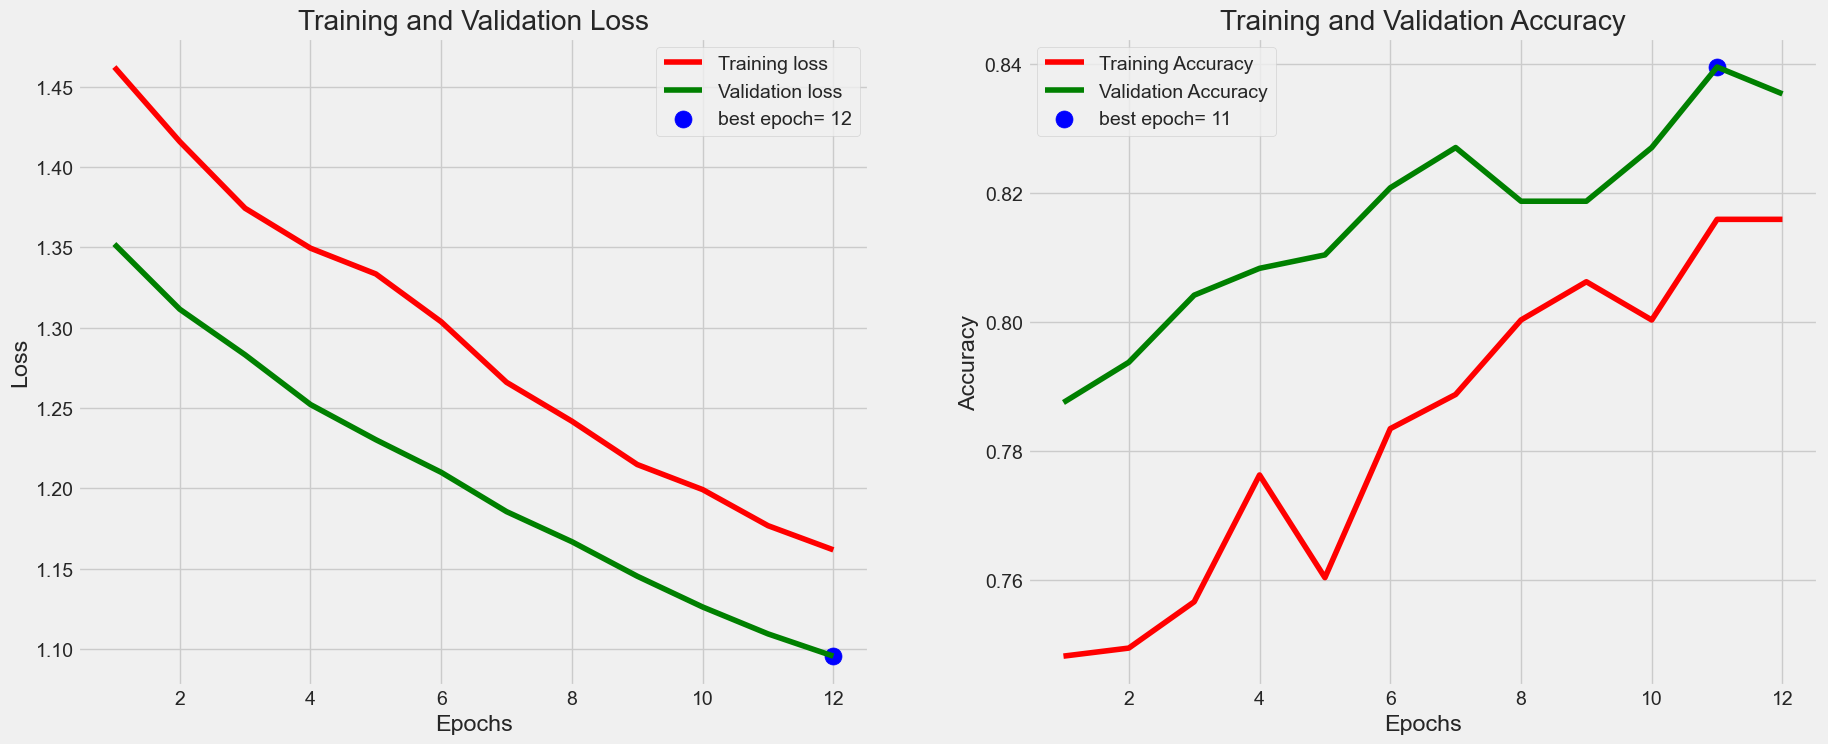

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [37]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9292 - loss: 1.0311
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7854 - loss: 1.1066
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8021 - loss: 2.6312
Train Loss:  1.0656890869140625
Train Accuracy:  0.90625
--------------------
Validation Loss:  1.0578736066818237
Validation Accuracy:  0.8125
--------------------
Test Loss:  2.645869493484497
Test Accuracy:  0.800000011920929


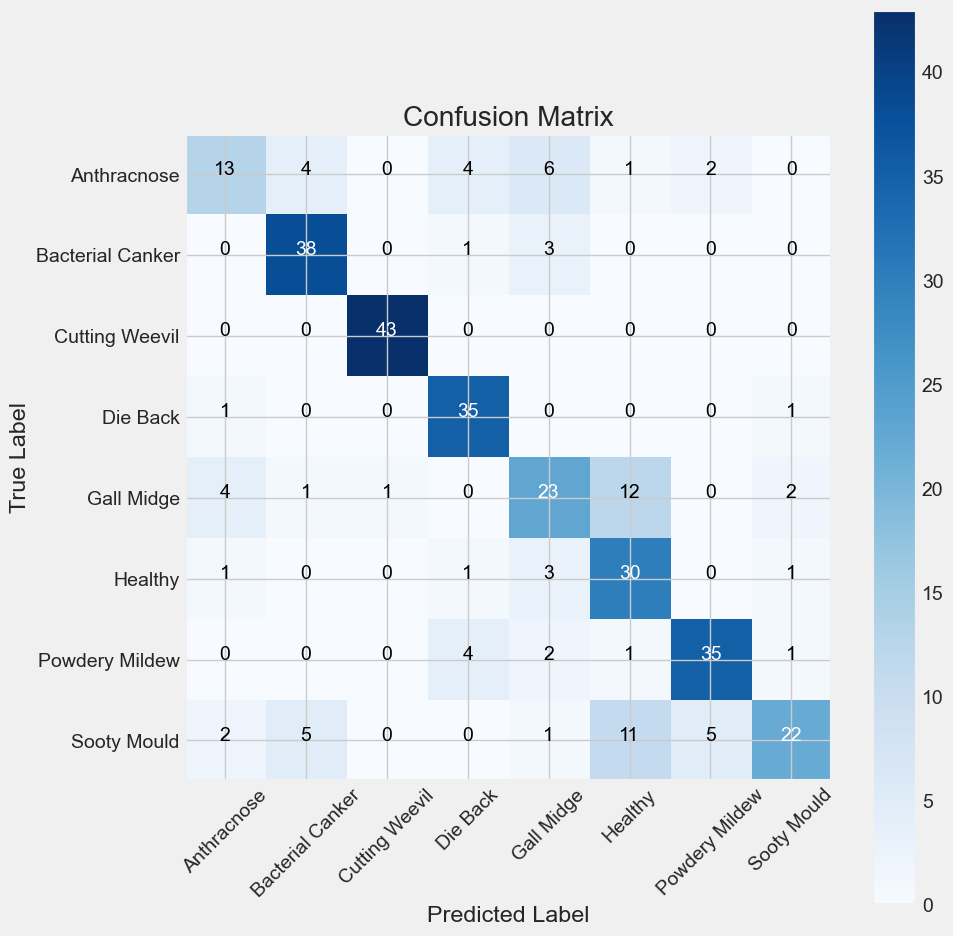

In [38]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [39]:
# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Display the test accuracy
print("Test Accuracy:", test_score[1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8021 - loss: 2.6312
Test Accuracy: 0.800000011920929
